# Set up

In [0]:
!pip install --quiet gensim

# Data Processing

In [0]:
!git clone https://github.com/yvchen/JointSLU.git

Cloning into 'JointSLU'...
remote: Enumerating objects: 85, done.
remote: Total 85 (delta 0), reused 0 (delta 0), pack-reused 85
Unpacking objects: 100% (85/85), done.


In [0]:
!ls

adc.json	 data	   model1.png  multi_acc.png	 sample_data
black_jeans.zip  JointSLU  model.png   multi_losses.png


In [0]:
import os

In [0]:
data_path = 'JointSLU/data'

os.listdir(data_path)

In [0]:
# i = 0
# tmp = []
# with open(os.path.join(data_path, 'atis-2.train.w-intent.iob')) as f:
#   for line in f:
#     if i <= 3:
#       print(line)
#       tmp.append(line.strip())
#       i += 1
#     else:
#       break
files = os.listdir(data_path)
tmp = []
for f in files:
  with open(os.path.join(data_path, f)) as f:
    for line in f:
      tmp.append(line.strip())

In [0]:
tmp[10], tmp[-100]

('BOS flights from ontario to florida EOS\tO O O B-fromloc.city_name O B-toloc.state_name atis_flight',
 'BOS information on afternoon flights from philadelphia to denver EOS\tO O O B-depart_time.period_of_day O O B-fromloc.city_name O B-toloc.city_name atis_flight')

In [0]:
len(tmp)

21708

In [0]:
def process_1(tmp):
  """splits and maps the corresponding labels with entities."""
  sentence = []
  sent_label = []
  entity = []
  entity_labels = []
  for i in tmp:
    sentence.append(i.split('\t')[0].split('BOS')[-1][:-3].strip())
    sent_label.append(i.split()[-1])
    a, b = i.split('EOS\t')
    t1, t2 = [], []
    for j in zip(a.split()[1:], b.split()[1:-1]):
      t1.append(j[0])
      t2.append(j[1])
    entity.append(t1)
    entity_labels.append(t2)
  return sentence, sent_label, entity, entity_labels

In [0]:
sent, sent_label, entity, entity_label = process_1(tmp)

In [0]:
sent[0:5], sent_label[0:5]

(['i want to fly from boston at 838 am and arrive in denver at 1110 in the morning',
  'show me all round trip flights between houston and las vegas',
  'i would like some information on a flight from denver to san francisco on united airlines',
  'what are the coach flights between dallas and baltimore leaving august tenth and returning august twelve',
  "i'm flying from boston to the bay area"],
 ['atis_flight', 'atis_flight', 'atis_flight', 'atis_flight', 'atis_flight'])

In [0]:
len(sent) == len(sent_label) and len(entity) == len(entity_label)

True

In [0]:
import pickle

In [0]:
!mkdir data

**Working with entities**

In [0]:
# make entity

new_entity = []

for i in entity:
  e1 = []
  for j in i:
    e2 = []
    for k in j:
      e2.append(k)
    e1.append(e2)
  new_entity.append(e1)
# len(new_entity[0][0]), len(new_entity[0][1])
new_entity[0]
print(len(new_entity))
print(len(entity_label))

all_entity = []

for i in zip(new_entity, entity_label):
  for j in zip(i[0], i[1]):
    all_entity.append([j[0], j[1]])

print(all_entity[:5])
print(len(all_entity))

21708
21708
[[['i'], 'O'], [['w', 'a', 'n', 't'], 'O'], [['t', 'o'], 'O'], [['f', 'l', 'y'], 'O'], [['f', 'r', 'o', 'm'], 'O']]
243291


In [0]:
def collate_labels(sample):
  """Function to collate the labels as key in dictionary."""
  unique_sample = {}
  for i in sample:
    if i[1] in unique_sample:
      unique_sample[i[1]].append(''.join(i[0]))
    else:
      unique_sample[i[1]] = [''.join(i[0])]
  return unique_sample

In [0]:
def find_unique(sample):
  """Function to club the data wrt to uniqueness."""
  unique_sample = collate_labels(sample)
  t = []
  for key in unique_sample:
    #print('{}-{}'.format(key, len(unique_sample[key])))
    t.append([key, len(unique_sample[key])])
    unique_sample[key] = set(unique_sample[key])
  return [[[j for j in i], key] for key in unique_sample for i in unique_sample[key]], t

In [0]:
a, t = find_unique(all_entity)
print(a[:5])
plot_x = []
plot_y = []
for i in t:
  plot_x.append(i[0])
  plot_y.append(i[1])

print(plot_x[0], plot_y[0])

[[['t', 'h', 'e'], 'O'], [['l', 'a', 'n', 'd', 'i', 'n', 'g', 's'], 'O'], [['p', 'r', 'e', 'f', 'e', 'r'], 'O'], [['t', 'h', 'a', 'n', 'k'], 'O'], [['r', 'e', 'p', 'r', 'e', 's', 'e', 'n', 't', 'e', 'd'], 'O']]
O 153778


In [0]:
import matplotlib.pyplot as plt

In [0]:
def plot_label_count(plot_x, plot_y):
  """Function to plot the labels wrt to counts"""
  fig = plt.figure(figsize=(18, 6))
  plt.bar(plot_x, plot_y, align='center', alpha=0.5)
  plt.xticks(plot_x, rotation=90)
  plt.ylabel('count')
  plt.title('Unique Values Count')
  plt.show()

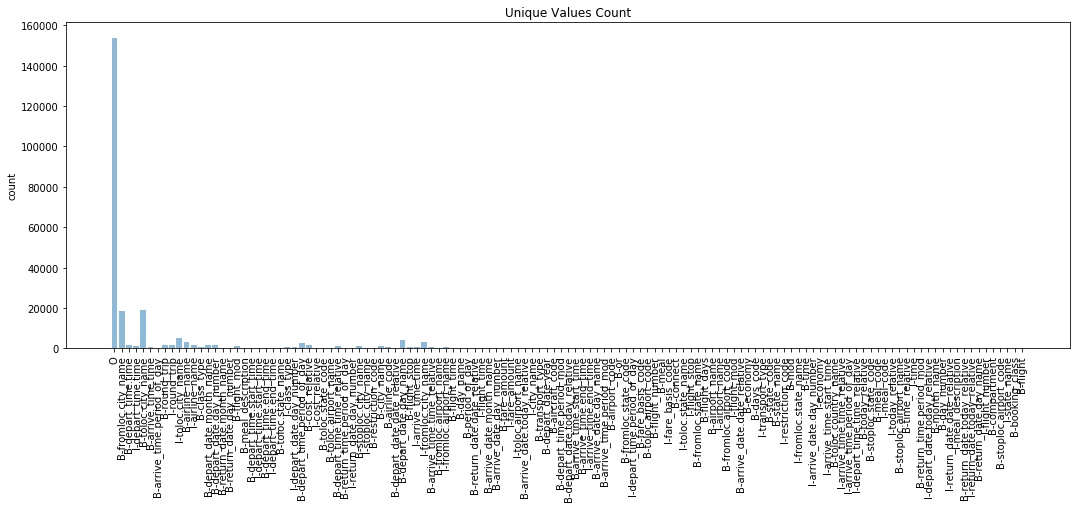

In [0]:
plot_label_count(plot_x, plot_y)

We can see from the plot that the list of words and the counts are not distributed evenly, we need to equailize it.

In [0]:
import numpy as np

In [0]:
def equalizer(sample, equalize_count=20000):
  """Function to equalize the data as per the count."""
  unique_sample = collate_labels(sample)
  for i in unique_sample:
    while len(unique_sample[i]) != equalize_count:
      offset = len(unique_sample[i]) - equalize_count
      if offset < 0:
        for _ in range(abs(offset)):
          ind = np.random.randint(0, len(unique_sample[i]))
          unique_sample[i].append(unique_sample[i][ind])
      if offset > 0:
        np.random.shuffle(unique_sample[i])
        unique_sample[i] = unique_sample[i][:equalize_count]
  return unique_sample

In [0]:
d = equalizer(all_entity) # equalizing entities

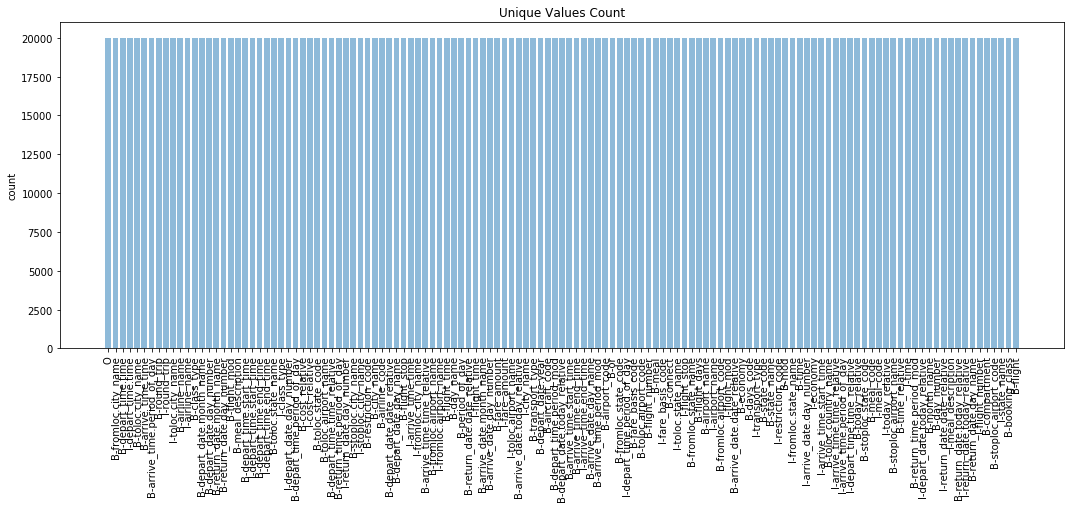

In [0]:
plot_x1 = []
plot_y1 = []

for i in d:
  plot_x1.append(i)
  plot_y1.append(len(d[i]))

plot_label_count(plot_x1, plot_y1)

All Labels have equal values now

In [0]:
pickle.dump({'all_entity_equalized': d}, open('data/equalized_entity', 'wb'))

In [0]:
all_entity = [[j, key] for key in d for j in d[key]]
len(all_entity)

2540000

In [0]:
def find_unique_intents(sample):
  """Function to club the data wrt to uniqueness."""
  unique_sample = collate_labels(sample)
  t = []
  for key in unique_sample:
    #print('{}-{}'.format(key, len(unique_sample[key])))
    t.append([key, len(unique_sample[key])])
    unique_sample[key] = set(unique_sample[key])
  return [[s, key] for key in unique_sample for s in unique_sample[key]], t

**Working with intents**

In [0]:
# working with intents and sentences

all_sent = [[i[0], i[1]] for i in zip(sent, sent_label)]
a, t = find_unique_intents(all_sent)
print(a[:5])
plot_x = []
plot_y = []
for i in t:
  plot_x.append(i[0])
  plot_y.append(i[1])

print(plot_x[0], plot_y[0])

[['show me the flights from san diego to newark by way of houston', 'atis_flight'], ['i would like to fly from columbus to phoenix through cincinnati in the afternoon', 'atis_flight'], ['give me the latest flight tomorrow on american airlines from milwaukee to tacoma', 'atis_flight'], ['show me the flights from san francisco to dallas on continental airlines', 'atis_flight'], ['show me all the flights from charlotte to cleveland', 'atis_flight']]
atis_flight 7972


In [0]:
d = collate_labels(all_sent)
len(d.keys())

27

In [0]:
2540000 // 27

94074

In [0]:
len(all_sent)

21708

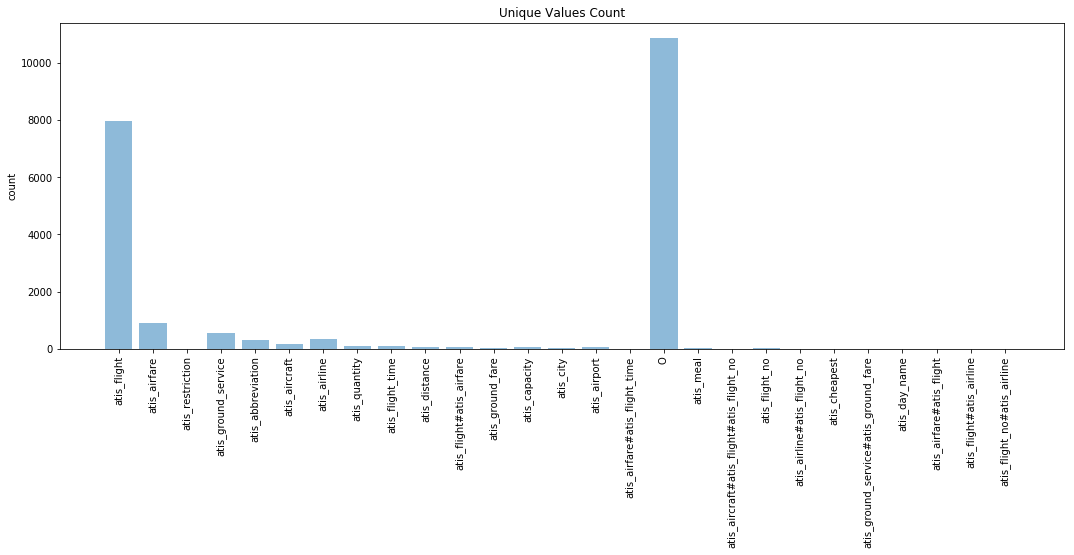

In [0]:
plot_label_count(plot_x, plot_y)

Since all the data corresponding to the labels are unabalanced, we need to make it consistent

In [0]:
%%time
equalized_intent = equalizer(all_sent, 94074)

CPU times: user 3.33 s, sys: 3.81 ms, total: 3.34 s
Wall time: 3.34 s


In [0]:
plot_x = []
plot_y = []
for i in equalized_intent:
  plot_x.append(i)
  plot_y.append(len(equalized_intent[i]))

print(plot_x[0], plot_y[0])

atis_flight 94074


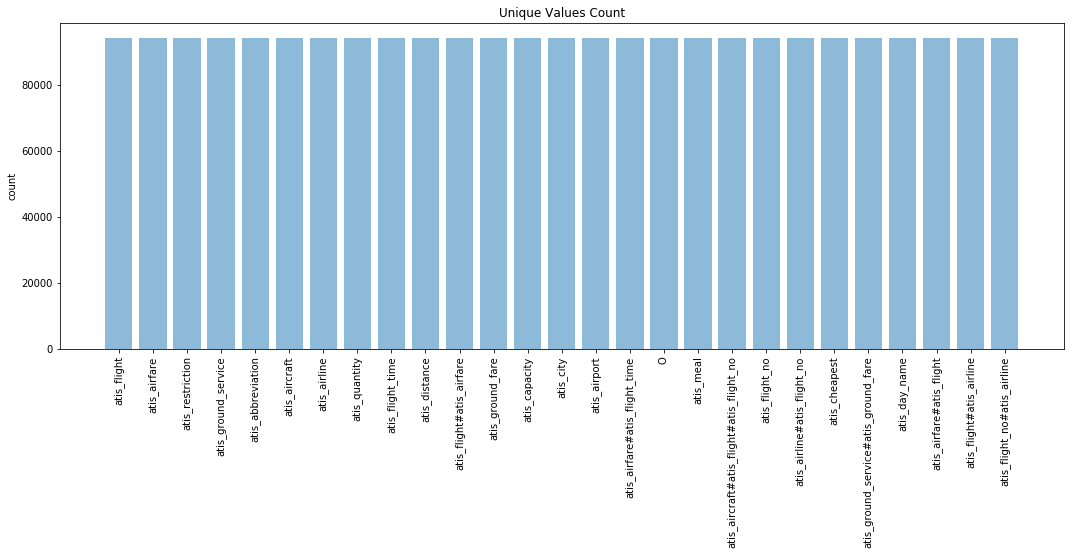

In [0]:
plot_label_count(plot_x, plot_y)

In [0]:
all_sent = [[j, i] for i in equalized_intent for j in equalized_intent[i]]
len(all_sent)

2539998

In [0]:
for i in range(2):
  all_sent.append(all_sent[i])
len(all_entity),len(all_sent)

(2540000, 2540000)

**Training gensim models**

In [0]:
from gensim.models import Word2Vec

In [0]:
data_intent = []
target_intent = []

for i in all_sent:
  data_intent.append(i[0])
  target_intent.append(i[1])

data_ner = []
target_ner = []

for i in all_entity:
  data_ner.append(i[0])
  target_ner.append(i[1])

len(data_intent) == len(target_intent) and len(data_ner) == len(target_ner)

True

In [0]:
import gc
gc.collect()

244

In [0]:
for i, v in enumerate(data_intent):
  data_intent[i] = v.split()

for i, v in enumerate(data_ner):
  data_ner[i] = [j for j in v]

data_intent[:5], data_ner[:5]

In [0]:
all_data = []
all_data.extend(data_intent)
all_data.extend(data_ner)
len(all_data)

5080000

In [0]:
em_model = Word2Vec(all_data,size=100, window=5, min_count=5, workers=4)

In [0]:
%%time
em_model.train(all_data, total_examples=len(data_intent), epochs=10)

CPU times: user 7min 58s, sys: 3.7 s, total: 8min 1s
Wall time: 4min 31s


(244431560, 450502920)

In [0]:
i_vec = em_model.wv[data_intent[0]]
i_vec.shape

(18, 100)

In [0]:
e_vec = em_model.wv[data_ner[0]]
e_vec.shape

(7, 100)

In [0]:
em_model.save('data/em_model')

In [0]:
!rm equalized_entity

In [0]:
!touch readme.md

In [0]:
tmp = {'data_ner': data_ner, 'target_ner': target_ner, 'data_intent': data_intent, 'target_intent': target_intent}
pickle.dump(tmp, open('data/data_target.pkl', 'wb'))

In [0]:
for i in zip(data_ner, target_ner):
  with open('data/ner.csv', 'a') as f:
    f.write('{},{}'.format(''.join(i[0]), i[1]))

for j in zip(data_intent, target_intent):
  with open('data/intent.csv', 'a') as f:
    f.write('{},{}'.format(' '.join(j[0]), j[1]))

In [0]:
!git init

Initialized empty Git repository in /content/.git/


In [0]:
!git remote add origin git@github.com:Xnsam/ATIS_dataset.git

In [0]:
!git add .

In [0]:
!git rm -r -f --cached JointSLU doc_data sample_data

In [0]:
!git rm --cached data.zip

rm 'data.zip'


In [0]:
!git status

In [0]:
!git config --global user.email "aksonsam@gmail.com"
!git config --global user.name "Xnsam"

In [0]:
!git commit -m "[add] version 1"

In [0]:
!git push -u origin master

Host key verification failed.
fatal: Could not read from remote repository.

Please make sure you have the correct access rights
and the repository exists.


In [0]:
!sudo add-apt-repository ppa:git-core/ppa -y
!sudo apt-get update
!sudo apt-get install git -y
!git --version

# Single model using keras

In [0]:
# importing all the necesaary files
import keras
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten, Add, Input, Activation
from keras.layers import Bidirectional, TimeDistributed, RepeatVector
from keras.layers.recurrent import LSTM

from keras.callbacks import ModelCheckpoint
from keras.utils.np_utils import to_categorical
from keras.preprocessing.sequence import pad_sequences

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold

from gensim.models import Word2Vec

import re
import pickle 
import json

Using TensorFlow backend.


In [0]:
data_path = 'data/raw_data'

data = pickle.load(open(data_path, 'rb'))

data.keys()

dict_keys(['x_ner', 'y_ner', 'x_intent', 'y_intent'])

**Train word vectors model**

In [0]:
model = Word2Vec([i.split() for i in data['x_intent']], size=100, window=1, min_count=1, workers=4)
model.train(data['x_intent'], total_examples=len(data['x_intent']), epochs=100)

(973, 42500)

In [0]:
data['x_intent'][0]

'i want to fly from baltimore to dallas round trip'

In [0]:
tmp = model.wv[data['x_intent'][0].split()]
tmp.shape

(10, 100)

In [0]:
# tmp = [[j for j in i] for i in data['x_ner']]
# tmp[0]

tmp = [[k for k in j] for i in data['x_ner'] for j in i]
tmp[0:10]

[['i'],
 ['w', 'a', 'n', 't'],
 ['t', 'o'],
 ['f', 'l', 'y'],
 ['f', 'r', 'o', 'm'],
 ['b', 'a', 'l', 't', 'i', 'm', 'o', 'r', 'e'],
 ['t', 'o'],
 ['d', 'a', 'l', 'l', 'a', 's'],
 ['r', 'o', 'u', 'n', 'd'],
 ['t', 'r', 'i', 'p']]

In [0]:
model.train([[k for k in j] for i in data['x_ner'] for j in i], total_examples=len(data['x_ner'])*2, epochs=100)

(942, 35700)

In [0]:
[[j for j in i] for i in data['x_ner'][0]]

[['i'],
 ['w', 'a', 'n', 't'],
 ['t', 'o'],
 ['f', 'l', 'y'],
 ['f', 'r', 'o', 'm'],
 ['b', 'a', 'l', 't', 'i', 'm', 'o', 'r', 'e'],
 ['t', 'o'],
 ['d', 'a', 'l', 'l', 'a', 's'],
 ['r', 'o', 'u', 'n', 'd'],
 ['t', 'r', 'i', 'p']]

In [0]:
tmp = model.wv[[[j for j in i] for i in data['x_ner'][0]][0]]
tmp.shape

(1, 100)

In [0]:
def convert_word2vecs(x, model):
  """Converts words into word to vector embeddings."""
  return np.array([model.wv[i] for i in x])

def convert_word2vecs_2(x, model):
  """Converts characteds into word vector embeddings."""
  return np.array([model.wv[i.split(' ')] for i in x])

def data_list_to_diction(sample_data):
  data = {}

In [0]:
raw_data = pickle.load(open('raw_data', 'rb'))

x_ner = raw_data['x_ner']
y_ner = raw_data['y_ner']

x_intent = raw_data['x_intent']
y_intent = raw_data['y_intent']

In [0]:
len(x_ner), len(x_intent)

(104962, 104962)

In [0]:
x_ner[:10]

[['d', 'i', 's', 't', 'a', 'n', 'c', 'e'],
 ['a', 'm', 'o', 'u', 'n', 't'],
 ['w', 'i', 't', 'h', 'o', 'u', 't'],
 ['s', 'h', 'o', 'u', 'l', 'd'],
 ['h', 'e', 'r', 'e'],
 ['m', 'a', 'n', 'y'],
 ['c', 'a', 'p', 'a', 'c', 'i', 't', 'y'],
 ['f', 'i', 'n', 'a', 'l'],
 ['c', 'h', 'a', 'r', 'g', 'e', 's'],
 ['s', 'p', 'e', 'n', 'd']]

# Uni models

In [2]:
import keras
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten, Add, Input, Activation
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import re
from gensim.models import Word2Vec
from sklearn.model_selection import StratifiedKFold
import pickle
import json

from keras.layers import Bidirectional, Activation, TimeDistributed,RepeatVector
from keras.layers.recurrent import LSTM

Using TensorFlow backend.


In [0]:
def convert_word2vecs(x,model):
  x_ = np.array([model.wv[i] for i in x])
  return x_

def convert_word2vecs_new(x,model):
  x_ = np.array([model.wv[i.split(' ')] for i in x])
  return x_

def data_list_to_diction(sample_data):
  data = {}
  for i,_ in enumerate(sample_data):
    if sample_data[i][1] not in data.keys():
      data[sample_data[i][1]] = [sample_data[i][0]]
    else:
      data[sample_data[i][1]].append(sample_data[i][0])
  return data

def get_unique_patterns(d):
  u = {}
  for i in d.keys():
    m = {}
    l = list(set(d[i]))
    m['pattern_strs'] = l
    m['pattern_len'] = len(l)
    u[i] = m
  return u

def show_plt(d):
  o = [i for i in d.keys()]
  y_pos = np.arange(len(d))
  p = [d[k]['pattern_len'] for k in d.keys()]
  plt.barh(y_pos, p,alpha=0.5)
  plt.yticks(y_pos, o)
  plt.xlabel('# of unique patterns')
  plt.ylabel('Unique Patterns')
  plt.show()
  return max(p)

def eq(d):
  max_num = max([d[i]['pattern_len'] for i in d.keys()])
  for i in d:
    while d[i]['pattern_len'] != max_num:
      offset = d[i]['pattern_len'] - max_num
      if offset < 0:
        for _ in range(abs(offset)):
          d[i]['pattern_strs'].append(np.random.choice(d[i]['pattern_strs']))
        d[i]['pattern_len'] = len(d[i]['pattern_strs'])
      if offset > 0:
        d[i]['pattern_strs'] = d[i]['pattern_strs'][:max_num]
        d[i]['pattern_len'] = len(d[i]['pattern_strs'])
  return d

# def eq(d):
#   max_num = max([d[i]['pattern_len']  for i in d.keys()])
#   for i in d:
#     if d[i]['pattern_len'] != max_num:
#       if d[i]['pattern_len'] > max_num:
#         offset = d[i]['pattern_len'] - max_num
#         d[i]['pattern_strs'] = d[i]['pattern_strs'][:max_num]
#         d[i]['pattern_len'] = len(d[i]['pattern_strs'])
#       elif d[i]['pattern_len'] < max_num:
#         offset = max_num - d[i]['pattern_len']
#         for _ in range(offset):
#           d[i]['pattern_strs'].append(np.random.choice(d[i]['pattern_strs']))
#         d[i]['pattern_len'] = len(d[i]['pattern_strs'])
#       else:
#         pass
# #   return d
# problem with this is like, any important data lying at the end will be lost.

def data_augment(sample, count=100):
  if type(sample) is dict:
    main_data = []
    for k in sample.keys():
      l = sample[k]
      for i in l:
        for _ in range(count):
          main_data.append([k, i])
    return main_data
  if type(sample) is list:
    sample_diction = data_list_to_diction(sample)
    return data_augment(sample_diction,count)

In [0]:
path = 'raw_data'
raw_data = pickle.load(open(path , 'rb'))

x_ner = raw_data['x_ner']
y_ner = raw_data['y_ner']
x_intent = raw_data['x_intent']
y_intent = raw_data['y_intent']

em_model = Word2Vec.load('em_model')

# visualize word2vectors

In [0]:
from sklearn.manifold import TSNE
import re
import matplotlib.pyplot as plt

In [7]:
vocab = list(em_model.wv.vocab)
X = em_model[vocab]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [0]:
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

In [0]:
df = pd.DataFrame(X_tsne, index=vocab, columns=["x", "y"])

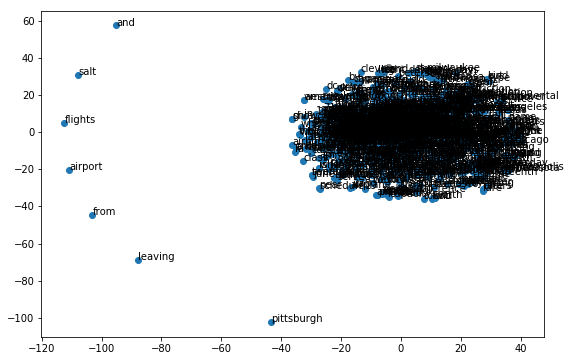

In [14]:
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(df['x'], df['y'])
for word, pos in df.iterrows():
  ax.annotate(word, pos)

plt.show()

# Data process continued

In [15]:
y_ner[0]

'O'

In [16]:
y_intent[0]

'atis_flight'

In [0]:
y_diction_ner = dict((v,i) for i,v in enumerate(list(set(y_ner))))
y_diction_intent = dict((v,i) for i,v in enumerate(list(set(y_intent))))

In [0]:
y_diction_ner

In [0]:
y_diction_intent

In [20]:
x_ner[0]

['d', 'i', 's', 't', 'a', 'n', 'c', 'e']

In [21]:
x_intent[0]

'BOS i want a flight that leaves from charlotte to newark that leaves in the afternoon or evening EOS'

In [22]:
x__ner = pad_sequences(convert_word2vecs(x_ner, em_model), maxlen=16, dtype='float32', padding='pre', truncating='pre', value=0.0)
x__ner.shape

(104962, 16, 100)

In [23]:
x__intent = pad_sequences(convert_word2vecs_new(x_intent, em_model), maxlen=16, dtype='float32', padding='pre', truncating='pre', value=0.0)
x__intent.shape

(104962, 16, 100)

In [0]:
y_rev_diction_ner = dict((v,i) for i,v in zip(y_diction_ner.keys(), y_diction_ner.values()))
y_rev_diction_intent = dict((v,i) for i,v in zip(y_diction_intent.keys(), y_diction_intent.values()))


In [0]:
y__ner = np.array([[y_diction_ner[w]] for w in y_ner])
y__intent = np.array([[y_diction_intent[w]] for w in y_intent])

In [26]:
print(x__ner.shape, y__ner.shape, x__intent.shape, y__intent.shape)

(104962, 16, 100) (104962, 1) (104962, 16, 100) (104962, 1)


In [0]:
x__intent = pad_sequences(convert_word2vecs_new(x_intent, em_model), maxlen=16, dtype='float32', padding='pre', truncating='pre', value=0.0)
x__intent.shape

In [0]:
features_ner, features_ner_val_x , labels_ner, labels_ner_val_y  = train_test_split(x__ner,y__ner,test_size=0.2,random_state=0)

In [0]:
features_intent, features_intent_val_x , labels_intent , labels_intent_val_y  = train_test_split(x__intent,y__intent,test_size=0.2,random_state=0)

In [32]:
print(features_intent.shape, features_intent_val_x.shape , labels_intent.shape, labels_intent_val_y.shape)

(83969, 16, 100) (20993, 16, 100) (83969, 1) (20993, 1)


# Model

In [0]:
from keras.layers import Conv1D, MaxPooling1D
from keras.activations import relu
from keras.layers.merge import Concatenate
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
from keras.utils import plot_model

kernel = [3, 4, 5]
feature_maps = 100

In [34]:
def model_new():
    ctx_input = Input(shape=(16,100), name='ctx_input_layer')
    ctx_cnn_1 = Conv1D(filters=feature_maps, kernel_size=kernel[0], activation='relu', name='ctx_cnn_1')(ctx_input)
    maxpool_cnn_1 = MaxPooling1D(pool_size=1, strides=1, padding='valid', name='ctx_maxpool_1')(ctx_cnn_1)
    
    ctx_cnn_2 = Conv1D(filters=feature_maps, kernel_size=kernel[1], activation='relu', name='ctx_cnn_2')(ctx_input)
    maxpool_cnn_2 = MaxPooling1D(pool_size=1, strides=1, padding='valid', name='ctx_maxpool_2')(ctx_cnn_2)
    
    ctx_cnn_3 = Conv1D(filters=feature_maps, kernel_size=kernel[2], activation='relu', name='ctx_cnn_3')(ctx_input)
    maxpool_cnn_3 = MaxPooling1D(pool_size=1, strides=1, padding='valid', name='ctx_maxpool_3')(ctx_cnn_3)
    
    ctx = keras.layers.concatenate([maxpool_cnn_1, maxpool_cnn_2, maxpool_cnn_3], axis=1)
    ctx_layer_1 = LSTM(32, name='ctx_layer_1')(ctx)
    ctx_layer_2 = Dropout(0.3, name='ctx_drop_layer_1')(ctx_layer_1)
    ctx_layer_3 = RepeatVector(32, name='ctx_layer_2')(ctx_layer_2)
    ctx_layer_4 = Bidirectional(LSTM(32, return_sequences=True), name='ctx_layer_3')(ctx_layer_3)
    ctx_layer_5 = Flatten(name='ctx_flatten_1')(ctx_layer_4)
    ctx_output = Dense(26, name='ctx_prediction', activation='softmax')(ctx_layer_5)
    model = Model(inputs=[ctx_input], outputs=[ctx_output])
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

intent_model = model_new()
intent_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ctx_input_layer (InputLayer)    (None, 16, 100)      0                                            
__________________________________________________________________________________________________
ctx_cnn_1 (Conv1D)              (None, 14, 100)      30100       ctx_input_layer[0][0]            
__________________________________________________________________________________________________
ctx_cnn_2 (Conv1D)              (None, 13, 100)      40100       ctx_input_layer[0][0]            
__________________________________________________________________________________________________
ctx_cnn_3 (Conv1D)   

In [0]:
from keras.utils import plot_model

In [0]:
plot_model(intent_model, to_file="intent_model.png")

In [0]:
def plot_history(history,name, num):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'val_loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(num, figsize=(8,5))
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'r', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    ## Accuracy
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'y', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy / Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy / Loss')
    plt.legend()
    plt.savefig(save_path + 'plot_image_{0}_{1}.svg'.format(name, num), format='svg')

In [38]:
import gc
gc.collect()

4287

In [0]:
!mkdir chkpts
save_path = 'chkpts'

# Training intent

In [43]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()
import keras.backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

Instructions for updating:
Use tf.cast instead.
--> Cross Validation Score [0.007328261872524971, 0.9987504462691896]
--> Cross Validation Score [0.034321681740744535, 0.992498213860443]
--> Cross Validation Score [0.003986937614186264, 0.999642750818696]
--> Cross Validation Score [0.0011922584355324264, 0.9998808743820359]
--> Cross Validation Score [0.0013614107404953978, 0.9998808317940774]


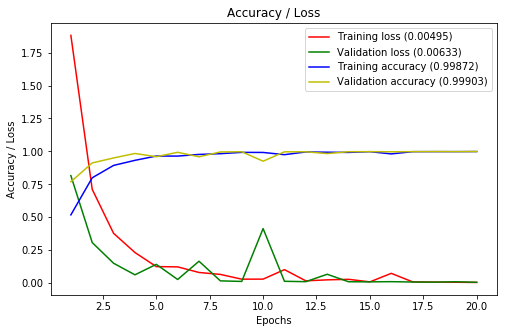

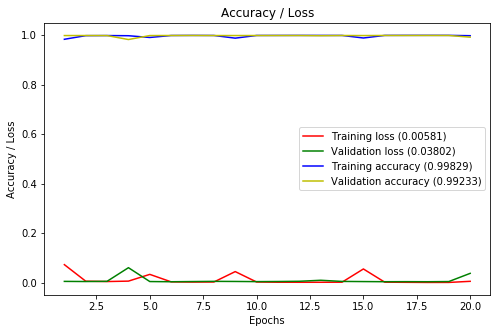

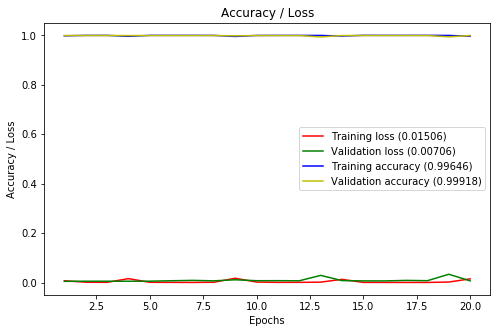

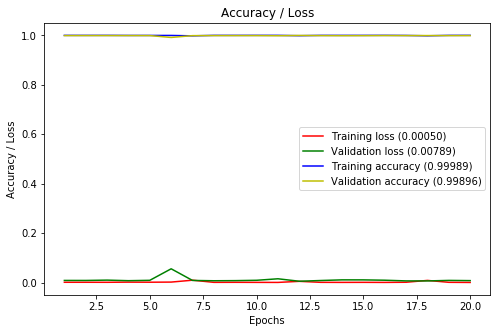

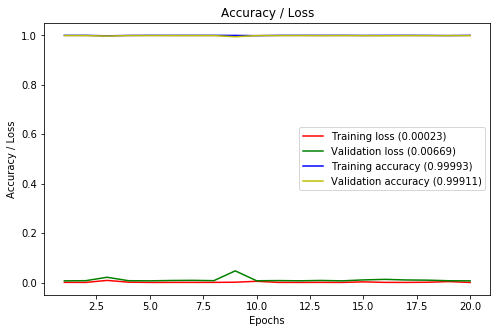

In [44]:
kfold = StratifiedKFold(n_splits=5, shuffle=True,random_state=16)
name = 'ctx'
i = 0
for train, test in kfold.split(features_intent, labels_intent):
    i += 1
    h = intent_model.fit(features_intent[train], to_categorical(labels_intent[train]),
                         batch_size=5000,
                         validation_split=0.2,
                         epochs=20,
                         verbose=0,
                         shuffle=True,
                         callbacks=[ModelCheckpoint(save_path + '/model_intent_run_1.h5', monitor='val_acc', verbose=0, save_best_only=True,mode='auto')])
    plot_history(h,name,i)
    scores = intent_model.evaluate(features_intent[test],to_categorical(labels_intent[test]),verbose=0)
    print('--> Cross Validation Score', scores)

# Training NER

In [45]:
def model_3():
    ner_input = Input(shape=(16,100), name='ner_input_layer')
    ner_cnn_1 = Conv1D(filters=feature_maps, kernel_size=kernel[0], activation='relu', name='ner_cnn_1')(ner_input)
    maxpool_cnn_1 = MaxPooling1D(pool_size=1, strides=1, padding='valid', name='ner_maxpool_1')(ner_cnn_1)
    
    ner_cnn_2 = Conv1D(filters=feature_maps, kernel_size=kernel[1], activation='relu', name='ner_cnn_2')(ner_input)
    maxpool_cnn_2 = MaxPooling1D(pool_size=1, strides=1, padding='valid', name='ner_maxpool_2')(ner_cnn_2)
    
    ner_cnn_3 = Conv1D(filters=feature_maps, kernel_size=kernel[2], activation='relu', name='ner_cnn_3')(ner_input)
    maxpool_cnn_3 = MaxPooling1D(pool_size=1, strides=1, padding='valid', name='ner_maxpool_3')(ner_cnn_3)
    
    ner = keras.layers.concatenate([maxpool_cnn_1, maxpool_cnn_2, maxpool_cnn_3], axis=1)
    ner_layer_1 = LSTM(128, name='ner_layer_1')(ner)
    ner_layer_2 = Dropout(0.3, name='ner_drop_layer_1')(ner_layer_1)
    ner_layer_3 = RepeatVector(32, name='ner_layer_4')(ner_layer_2)
    ner_layer_4 = Bidirectional(LSTM(32, return_sequences=True), name='ner_layer_5')(ner_layer_3)
    ner_layer_5 = Flatten(name='ner_flatten_1')(ner_layer_4)
    ner_output = Dense(127, name='predictions_layer' ,activation='softmax')(ner_layer_5)
    model = Model(inputs=[ner_input], outputs=[ner_output])
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

ner_model = model_3()
ner_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ner_input_layer (InputLayer)    (None, 16, 100)      0                                            
__________________________________________________________________________________________________
ner_cnn_1 (Conv1D)              (None, 14, 100)      30100       ner_input_layer[0][0]            
__________________________________________________________________________________________________
ner_cnn_2 (Conv1D)              (None, 13, 100)      40100       ner_input_layer[0][0]            
__________________________________________________________________________________________________
ner_cnn_3 (Conv1D)              (None, 12, 100)      50100       ner_input_layer[0][0]            
__________________________________________________________________________________________________
ner_maxpoo

In [0]:
plot_model(ner_model, to_file="ner_model.png")

In [0]:
features_ner, features_ner_val_x , labels_ner, labels_ner_val_y  = train_test_split(x__ner,y__ner,test_size=0.2,random_state=0)

In [49]:
print(features_ner.shape, features_ner_val_x.shape , labels_ner.shape, labels_ner_val_y.shape)

(83969, 16, 100) (20993, 16, 100) (83969, 1) (20993, 1)


--> Cross Validation Score [0.8215323472297656, 0.6641529600415418]
--> Cross Validation Score [0.7815931427884824, 0.6731260773586134]
--> Cross Validation Score [0.7702587520966914, 0.6733539707391855]
--> Cross Validation Score [0.7656663282394693, 0.6755144646478488]
--> Cross Validation Score [0.760489888785632, 0.6735157090024614]


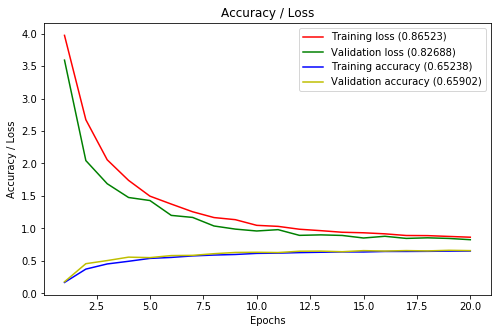

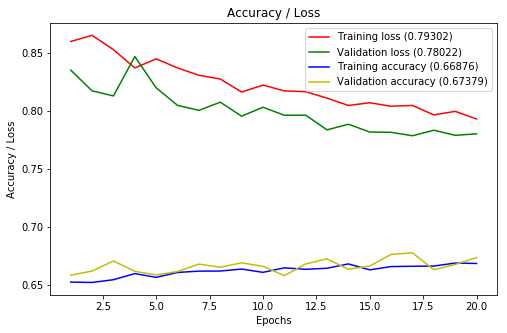

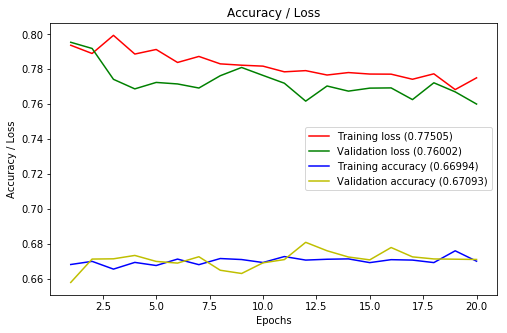

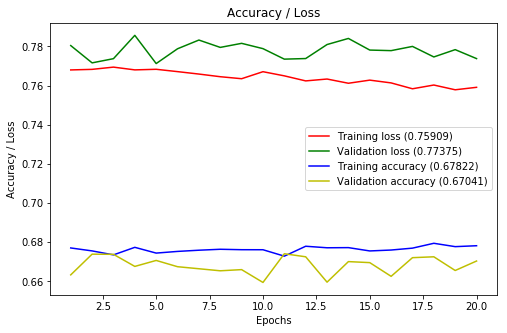

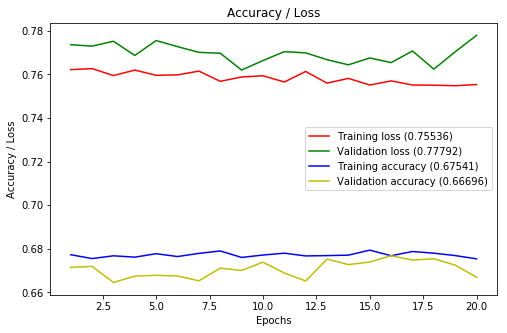

In [50]:
kfold = StratifiedKFold(n_splits=5, shuffle=True,random_state=16)
name = 'ner'
i = 0
for train1, test1 in kfold.split(features_ner, labels_ner):
    i += 1
    h = ner_model.fit(features_ner[train1], 
                      to_categorical(labels_ner[train1]),
                      batch_size=5000,
                      validation_split=0.2, 
                      epochs=20,
                      verbose=0,
                      shuffle=True, 
                      callbacks=[ModelCheckpoint(save_path+'/model_ner_run_1.h5', monitor='val_acc', verbose=0, save_best_only=True,mode='auto')])
    plot_history(h, name , i)
    scores = ner_model.evaluate(features_ner[test1],to_categorical(labels_ner[test1]),verbose=0)
    print('--> Cross Validation Score', scores)